In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [77]:
import numpy as np

class ActivationFunctions:
        

    def unipolar(data,derivative = False):
        return ActivationFunctions.Sigmoid(data,derivative )
    
    def bipolar(data,derivative = False):
        return ActivationFunctions.arctg(data,derivative)
    
    def Sigmoid(data,derivative = False):
        if derivative:
                   
            return (1-data)*data
        
        temp = np.array(data)
        return 1.0/(1.0+np.exp(-temp))
    
        
    def arctg(data,derivative = False):
        if derivative:
            return 1-(data*data)     

        return -(1.0-np.exp(np.array(data)))/(1.0+np.exp(np.array(data)))
    
    
    
    
    def Default(data,derivative=False):
        return ActivationFunctions.unipolar(data,derivative)

class LossFunctions:
    
    def Default(estimator,goal,derivative=False):
        return LossFunctions.AE(estimator,goal,derivative)
    def AE(estimator,goal,derivative=False):
        
        if derivative:
            return estimator-goal
        return np.power((estimator-goal),2)/2
        
        

class Layer:
    
    def __init__(self,shape,function=ActivationFunctions.Default) -> None:
        assert len(shape)==2
        assert isinstance(shape[0],int) and isinstance(shape[1],int)
        assert shape[0]>0 and shape[1]>0
        self.function=function
        self.shape = shape

        self._init_matrix()
        self.output=None
        self.input=None

    def __init__(self,shape_x:int,shape_y:int,function=ActivationFunctions.Default) -> None:
        assert shape_y>0 and shape_x>0

        self.shape = (shape_x,shape_y)
        self.function=function
        self._init_matrix()
        self.output=None
        self.input=None

    def _init_matrix(self):
        self.matrix = (np.random.randn(self.shape[0],self.shape[1]))
#         self.matrix = np.array([ [1.0 for i in range(self.shape[1])] for y in range(self.shape[0])])
        self.bias=np.random.randn(self.shape[1])


    def forward(self,data,function=None):
        
        if function in [None]:
            function = self.function

        self.input=data.copy()
        temp=np.dot(data,self.matrix)
        temp_shape = temp.shape
        
        self.dot = np.reshape(temp.copy()-self.bias,temp_shape)

#             print(self.dot,"####",)
        self.output = function(self.dot)
        return self.output.copy()
    

In [103]:
performance = []
class Model:

    def __init__(self):
        self.layers=[] # tymczasowe wartości, które potem są wykorzystywne do kompilacji modelu
        self.structure=[] # zbiór obiektów Layer
        self.learningFactor=0.2
        self.dataset={}
        self.loss_v=None
    def addLayer(self,numberOfNeurons:int,function=ActivationFunctions.Default):
        assert numberOfNeurons>0
        # TODO to validate function
        self.layers.append((numberOfNeurons,function))
        
    def compileModel(self):
        assert len(self.layers)>=2
        self.structure=[]
        for i in range(len(self.layers)-1):
            self.structure.append(Layer(self.layers[i][0],self.layers[i+1][0],self.layers[i+1][1]))
            
    def forward(self,data):
        assert len(self.structure) >=1
        output = data
        for i in self.structure:
            output = i.forward(output)#.copy()
        return output#.copy()
    
    def upload_test_dataset(self,data): #TODO add validation
        self.dataset['test'] = data
        
    def upload_train_dataset(self,data): #TODO add validation
        self.dataset['train'] = data
    
    def loss(self,goal):
        return self.function(self.structure[-1].output,goal)
    
    def evaluate(self):
        suma = 0.0
        for x,y in zip(self.dataset['train']['egzo'],self.dataset['train']['endo']):
            temp = (self.forward(x)-y)
            temp *= temp
            suma +=temp
        return suma
        
    def SGD(self,x,y):
        out = x
        for i in range(len(self.structure)):
            out = self.structure[i].forward(out)
        self.loss_v=self.loss(y,LossFunctions.AE)

        nabla_w = [0]*len(self.structure)
        nabla_b = [0]*len(self.structure)

        delta = LossFunctions.AE(self.structure[-1].output,y,derivative=True) \
                * self.structure[-1].function(self.structure[-1].output,derivative=True)
        
        self.structure[-1].input = np.expand_dims(self.structure[-1].input, axis=1)
        
        delta = np.expand_dims(delta, axis=1)
        nabla_b[-1] = delta.copy()
        nabla_w[-1]= np.dot( self.structure[-1].input,delta.T)
        
        
        for l in range(2,len(self.structure)+1):
            
            z=None
            
            sp=self.structure[-l].function(self.structure[-l].output,derivative=True)

            delta = np.dot(delta,self.structure[-l+1].matrix.T)*sp
            nabla_b[-l] = delta.copy()

            self.structure[-l].input = np.expand_dims(self.structure[-l].input, axis=1)

            nabla_w[-l] = np.dot(self.structure[-l].input,delta)

        return nabla_w,nabla_b

    def train(self):
        global performance
        self.learningFactor=0.2
        counter=400
        while counter>=0:
            counter-=1

            arr = None
            for x,y in zip(self.dataset['train']['egzo'],self.dataset['train']['endo']):
                nabla_w, nabla_b=self.SGD(x,y)

                for i  in range(len(self.structure)):

                    self.structure[i].matrix = self.structure[i].matrix - np.multiply(self.learningFactor,nabla_w[i])
                    
                   
                    temp_shape=self.structure[i].bias.shape
                    
                    self.structure[i].bias = self.structure[i].bias + np.multiply(self.learningFactor,nabla_b[i])
            performance.append(self.evaluate())
            
                    
                    

    

In [104]:
performance = []
model = Model()

model.addLayer(4,ActivationFunctions.bipolar)
model.addLayer(4,ActivationFunctions.bipolar)
model.addLayer(1,ActivationFunctions.bipolar)


model.compileModel()
# train_dataset= {
#     'egzo': np.array([[1,1,0,0],[1,0,0,0],[0,1,0,0],[0,0,0,0],[1,1,1,0],[1,0,1,0],[0,1,1,0],[0,0,1,0],[1,1,0,1],[1,0,0,1],[0,1,0,1],[0,0,0,1],[1,1,1,1],[1,0,1,1],[0,1,1,1],[0,0,1,1]]),
#     'endo':np.array([ [1,0],      [0,1],      [0,1],      [1,0],      [0,1],      [1,0],      [1,0],      [0,1],      [0,1],      [1,0],      [1,0],      [0,0],      [1,0],      [0,1],      [0,1],      [1,0]])
# }

train_dataset= {
    'egzo': np.array([[1,1,0,0],[1,0,0,0],[1,1,1,1]]), 
    'endo':np.array([ [1],      [0],      [0.5]])
}


model.upload_train_dataset(train_dataset)
print(model.forward([1,0,0,0]))
print(model.forward([1,1,0,0]))
print(model.forward([1,1,1,1]))

one=model.train()
one

[0.97118199]
[0.99834653]
[0.99797786]
delta [-5.46338024e-06]
self.structure[-1].input [[-0.96642398]
 [ 0.84995598]
 [-0.95528688]
 [-0.46290073]]
[[ 5.27994169e-06]
 [-4.64363272e-06]
 [ 5.21909548e-06]
 [ 2.52900270e-06]]
NABLA_B [array([[ 3.62231645e-07, -3.03795698e-06,  1.12920202e-06,
         1.08644800e-05]]), array([[-5.46338024e-06]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [-2.37108771 -1.08149897 -0.48369555 -0.05967022]
NABLA_B [array([[ 3.62231645e-07, -3.03795698e-06,  1.12920202e-06,
         1.08644800e-05]]), array([[-5.46338024e-06]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [-0.99407519]
delta [0.05516806]
self.structure[-1].input [[-0.88298757]
 [ 0.55419557]
 [-0.93354544]
 [ 0.3842755 ]]
[[-0.04871271]
 [ 0.03057389]
 [-0.05150189]
 [ 0.02119973]]
NABLA_B [array([[-0.01220636,  0.07657342, -0.01675837, -0.11900764]]), array([[0.05516806]])]
np.reshape(self.s

delta [-0.0538157]
self.structure[-1].input [[-0.96073121]
 [ 0.3269366 ]
 [-0.9437076 ]
 [ 0.3596453 ]]
[[ 0.05170242]
 [-0.01759432]
 [ 0.05078628]
 [-0.01935456]]
NABLA_B [array([[ 0.00226171, -0.0888529 ,  0.01108833,  0.13336155]]), array([[-0.0538157]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45237295 -0.21284764 -0.60894791 -0.88979945]]
NABLA_B [array([[ 0.00226171, -0.0888529 ,  0.01108833,  0.13336155]]), array([[-0.0538157]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47326861]]
delta [-0.01240112]
self.structure[-1].input [[-0.86396808]
 [-0.20571695]
 [-0.91614304]
 [ 0.82803571]]
[[ 0.01071417]
 [ 0.00255112]
 [ 0.0113612 ]
 [-0.01026857]]
NABLA_B [array([[ 0.00174885, -0.02199702,  0.0037726 ,  0.01108072]]), array([[-0.01240112]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45181804 -0.2439894  -0.6052671 

delta [-0.02233529]
self.structure[-1].input [[-0.96094399]
 [ 0.34146901]
 [-0.9457822 ]
 [ 0.20752902]]
[[ 0.02146296]
 [-0.00762681]
 [ 0.02112432]
 [-0.00463522]]
NABLA_B [array([[ 0.00094749, -0.03704084,  0.00445108,  0.06139892]]), array([[-0.02233529]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45108135 -0.22376531 -0.59647754 -0.77066064]]
NABLA_B [array([[ 0.00094749, -0.03704084,  0.00445108,  0.06139892]]), array([[-0.02233529]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48850179]]
delta [0.01155885]
self.structure[-1].input [[-0.86416216]
 [-0.21508986]
 [-0.91770611]
 [ 0.7974255 ]]
[[-0.00998872]
 [-0.00248619]
 [-0.01060763]
 [ 0.00921732]]
NABLA_B [array([[-0.00163382,  0.02071229, -0.0034536 , -0.01208644]]), array([[0.01155885]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45037559 -0.24272411 -0.5940063

np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.49435434]]
delta [0.00675348]
self.structure[-1].input [[-0.99851298]
 [-0.0500458 ]
 [-0.99637777]
 [ 0.58854329]]
[[-0.00674344]
 [-0.00033798]
 [-0.00672902]
 [ 0.00397472]]
NABLA_B [array([[-1.11189960e-05,  1.28002358e-02, -9.21580491e-05,
        -1.27999666e-02]]), array([[0.00675348]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45256951 -0.22251646 -0.59415743 -0.69263418]]
NABLA_B [array([[-1.11189960e-05,  1.28002358e-02, -9.21580491e-05,
        -1.27999666e-02]]), array([[0.00675348]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.49272177]]
delta [-0.01284402]
self.structure[-1].input [[-0.96089137]
 [ 0.34384288]
 [-0.94640822]
 [ 0.10501259]]
[[ 0.01234171]
 [-0.00441633]
 [ 0.01215569]
 [-0.00134878]]
NABLA_B [array([[ 0.00054436, -0.0215205 ,  0.00252645,  0.03684362]]

delta [-0.00872736]
self.structure[-1].input [[-0.96084582]
 [ 0.34536856]
 [-0.9467848 ]
 [ 0.03531811]]
[[ 0.00838565]
 [-0.00301416]
 [ 0.00826294]
 [-0.00030823]]
NABLA_B [array([[ 0.00036951, -0.0147318 ,  0.00170261,  0.02546601]]), array([[-0.00872736]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45390607 -0.20457415 -0.593938   -0.66340975]]
NABLA_B [array([[ 0.00036951, -0.0147318 ,  0.00170261,  0.02546601]]), array([[-0.00872736]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48581559]]
delta [0.00509543]
self.structure[-1].input [[-0.86338628]
 [-0.2417358 ]
 [-0.91793308]
 [ 0.76101556]]
[[-0.00439932]
 [-0.00123175]
 [-0.00467726]
 [ 0.0038777 ]]
NABLA_B [array([[-0.0007175 ,  0.00919818, -0.00151161, -0.00626505]]), array([[0.00509543]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45361477 -0.2123065  -0.5929546

delta [0.00398734]
self.structure[-1].input [[-0.8631545 ]
 [-0.24867625]
 [-0.91796569]
 [ 0.75050302]]
[[-0.00344169]
 [-0.00099156]
 [-0.00366024]
 [ 0.00299251]]
NABLA_B [array([[-0.00056109,  0.0072145 , -0.00118105, -0.00511431]]), array([[0.00398734]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45455584 -0.20452528 -0.59281354 -0.62768257]]
NABLA_B [array([[-0.00056109,  0.0072145 , -0.00118105, -0.00511431]]), array([[0.00398734]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.4879424]]
delta [0.00326868]
self.structure[-1].input [[-0.99850966]
 [-0.10185465]
 [-0.99641863]
 [ 0.54641645]]
[[-0.00326381]
 [-0.00033293]
 [-0.00325698]
 [ 0.00178606]]
NABLA_B [array([[-5.3665215e-06,  6.2392854e-03, -4.3979928e-05, -6.7347406e-03]]), array([[0.00326868]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45477921 -0.20288734 -0

np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45536117 -0.19822837 -0.59273063 -0.60778961]]
NABLA_B [array([[-0.00045532,  0.00586895, -0.00095766, -0.00429746]]), array([[0.00323696]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48603454]]
delta [0.0025751]
self.structure[-1].input [[-0.99850845]
 [-0.11735615]
 [-0.99643092]
 [ 0.53291248]]
[[-0.00257126]
 [-0.0003022 ]
 [-0.00256591]
 [ 0.0013723 ]]
NABLA_B [array([[-4.22486710e-06,  4.92347733e-03, -3.44990155e-05,
        -5.44039680e-03]]), array([[0.0025751]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45554246 -0.19686548 -0.59310679 -0.60842052]]
NABLA_B [array([[-4.22486710e-06,  4.92347733e-03, -3.44990155e-05,
        -5.44039680e-03]]), array([[0.0025751]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48525478]]


self.structure[-1].input [[-0.99850754]
 [-0.12803723]
 [-0.99643951]
 [ 0.52338608]]
[[-0.00216662]
 [-0.00027782]
 [-0.00216213]
 [ 0.00113567]]
NABLA_B [array([[-3.55856074e-06,  4.15302677e-03, -2.89824935e-05,
        -4.66412291e-03]]), array([[0.00216986]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45610183 -0.19267256 -0.59301322 -0.59446988]]
NABLA_B [array([[-3.55856074e-06,  4.15302677e-03, -2.89824935e-05,
        -4.66412291e-03]]), array([[0.00216986]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48404762]]
delta [-0.00453339]
self.structure[-1].input [[-0.96075667]
 [ 0.34901245]
 [-0.94736057]
 [-0.07814896]]
[[ 0.00435548]
 [-0.00158221]
 [ 0.00429475]
 [ 0.00035428]]
NABLA_B [array([[ 0.00019165, -0.00774704,  0.00087301,  0.01334005]]), array([[-0.00453339]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.456

delta [-0.00385155]
self.structure[-1].input [[-0.96073233]
 [ 0.3502893 ]
 [-0.94749628]
 [-0.10532431]]
[[ 0.00370031]
 [-0.00134916]
 [ 0.00364933]
 [ 0.00040566]]
NABLA_B [array([[ 0.00016278, -0.00660108,  0.00073942,  0.01131673]]), array([[-0.00385155]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45673059 -0.18569862 -0.59309577 -0.58408874]]
NABLA_B [array([[ 0.00016278, -0.00660108,  0.00073942,  0.01131673]]), array([[-0.00385155]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48133629]]
delta [0.00235898]
self.structure[-1].input [[-0.86264435]
 [-0.26245632]
 [-0.91800498]
 [ 0.72823657]]
[[-0.00203496]
 [-0.00061913]
 [-0.00216555]
 [ 0.00171789]]
NABLA_B [array([[-0.00033175,  0.00429161, -0.00069681, -0.003292  ]]), array([[0.00235898]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45659913 -0.18919738 -0.5926606

NABLA_B [array([[-0.00028151,  0.00364839, -0.00059083, -0.00286335]]), array([[0.00200161]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45725143 -0.18475369 -0.59264742 -0.56452834]]
NABLA_B [array([[-0.00028151,  0.00364839, -0.00059083, -0.00286335]]), array([[0.00200161]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.4820596]]
delta [0.00149024]
self.structure[-1].input [[-0.99850546]
 [-0.15017006]
 [-0.99645781]
 [ 0.50308338]]
[[-0.00148801]
 [-0.00022379]
 [-0.00148496]
 [ 0.00074972]]
NABLA_B [array([[-2.44264671e-06,  2.85814425e-03, -1.97778009e-05,
        -3.32018710e-03]]), array([[0.00149024]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45736355 -0.18386596 -0.5928798  -0.56500965]]
NABLA_B [array([[-2.44264671e-06,  2.85814425e-03, -1.97778009e-05,
        -3.32018710e-03]]), array([[0.00149024]])]
np.reshape(

np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45770019 -0.18166364 -0.59285917 -0.55759985]]
NABLA_B [array([[-2.21472065e-06,  2.59290689e-03, -1.79041036e-05,
        -3.03742082e-03]]), array([[0.00135126]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.4809487]]
delta [-0.002948]
self.structure[-1].input [[-0.96069064]
 [ 0.35282327]
 [-0.94771512]
 [-0.14885964]]
[[ 0.00283211]
 [-0.00104012]
 [ 0.00279386]
 [ 0.00043884]]
NABLA_B [array([[ 0.00012457, -0.00507572,  0.00056315,  0.00861657]]), array([[-0.002948]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45772599 -0.17961133 -0.59297896 -0.56053813]]
NABLA_B [array([[ 0.00012457, -0.00507572,  0.00056315,  0.00861657]]), array([[-0.002948]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.4798186]]
delta [0.00182345]
self.st

NABLA_B [array([[ 0.00011563, -0.00471709,  0.000522  ,  0.00798157]]), array([[-0.00273634]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45800993 -0.17794241 -0.59295678 -0.55417579]]
NABLA_B [array([[ 0.00011563, -0.00471709,  0.000522  ,  0.00798157]]), array([[-0.00273634]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47940642]]
delta [0.00169638]
self.structure[-1].input [[-0.86231184]
 [-0.27036211]
 [-0.91801316]
 [ 0.7145324 ]]
[[-0.00146281]
 [-0.00045864]
 [-0.0015573 ]
 [ 0.00121212]]
NABLA_B [array([[-0.00023864,  0.00309831, -0.00050041, -0.00248614]]), array([[0.00169638]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45791595 -0.1804489  -0.5926479  -0.55048594]]
NABLA_B [array([[-0.00023864,  0.00309831, -0.00050041, -0.00248614]]), array([[0.00169638]])]
np.reshape(self.structure[i].bias - np.multiply(self.lea

NABLA_B [array([[-0.00021808,  0.00283404, -0.00045705, -0.00230092]]), array([[0.00154989]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45828204 -0.17817262 -0.59265339 -0.54300802]]
NABLA_B [array([[-0.00021808,  0.00283404, -0.00045705, -0.00230092]]), array([[0.00154989]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.48021027]]
delta [0.00111554]
self.structure[-1].input [[-0.99850377]
 [-0.16599926]
 [-0.99647159]
 [ 0.48809697]]
[[-0.00111388]
 [-0.00018518]
 [-0.00111161]
 [ 0.00054449]]
NABLA_B [array([[-1.82840511e-06,  2.14271986e-03, -1.47344266e-05,
        -2.55025769e-03]]), array([[0.00111554]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45836891 -0.17746755 -0.59283327 -0.54341833]]
NABLA_B [array([[-1.82840511e-06,  2.14271986e-03, -1.47344266e-05,
        -2.55025769e-03]]), array([[0.00111554]])]
np.reshape

delta [0.00139083]
self.structure[-1].input [[-0.86210665]
 [-0.27482902]
 [-0.91801341]
 [ 0.70643856]]
[[-0.00119905]
 [-0.00038224]
 [-0.0012768 ]
 [ 0.00098254]]
NABLA_B [array([[-0.00019576,  0.00254687, -0.00041   , -0.00209633]]), array([[0.00139083]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45872418 -0.17551312 -0.59266436 -0.53421875]]
NABLA_B [array([[-0.00019576,  0.00254687, -0.00041   , -0.00209633]]), array([[0.00139083]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47949012]]
delta [0.00098713]
self.structure[-1].input [[-0.99850304]
 [-0.172358  ]
 [-0.99647735]
 [ 0.48196463]]
[[-0.00098566]
 [-0.00017014]
 [-0.00098366]
 [ 0.00047576]]
NABLA_B [array([[-1.61809785e-06,  1.89729359e-03, -1.30125483e-05,
        -2.28032518e-03]]), array([[0.00098713]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45880216 -

delta [-0.00209041]
self.structure[-1].input [[-0.96063396]
 [ 0.35703146]
 [-0.94799266]
 [-0.20277114]]
[[ 0.00200811]
 [-0.00074634]
 [ 0.00198169]
 [ 0.00042387]]
NABLA_B [array([[ 8.83561253e-05, -3.61876544e-03,  3.96837947e-04,
         6.04043765e-03]]), array([[-0.00209041]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.4590601  -0.17204693 -0.59290855 -0.53191166]]
NABLA_B [array([[ 8.83561253e-05, -3.61876544e-03,  3.96837947e-04,
         6.04043765e-03]]), array([[-0.00209041]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47798498]]
delta [0.00130435]
self.structure[-1].input [[-0.86203951]
 [-0.27622375]
 [-0.91801287]
 [ 0.70385307]]
[[-0.0011244 ]
 [-0.00036029]
 [-0.00119741]
 [ 0.00091807]]
NABLA_B [array([[-0.00018363,  0.0023906 , -0.00038443, -0.00198343]]), array([[0.00130435]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),

NABLA_B [array([[-0.00017068,  0.0022237 , -0.00035714, -0.00186152]]), array([[0.00121203]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45929124 -0.17224485 -0.59268445 -0.52332931]]
NABLA_B [array([[-0.00017068,  0.0022237 , -0.00035714, -0.00186152]]), array([[0.00121203]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47863335]]
delta [0.00084528]
self.structure[-1].input [[-0.9985021 ]
 [-0.1801428 ]
 [-0.99648464]
 [ 0.47436644]]
[[-0.00084401]
 [-0.00015227]
 [-0.00084231]
 [ 0.00040097]]
NABLA_B [array([[-1.38590012e-06,  1.62602413e-03, -1.11149616e-05,
        -1.97784302e-03]]), array([[0.00084528]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45935924 -0.17168057 -0.59282508 -0.52367835]]
NABLA_B [array([[-1.38590012e-06,  1.62602413e-03, -1.11149616e-05,
        -1.97784302e-03]]), array([[0.00084528]])]
np.reshape

np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45960361 -0.17032949 -0.59282755 -0.51903021]]
NABLA_B [array([[-1.29584290e-06,  1.52072664e-03, -1.03801087e-05,
        -1.85913260e-03]]), array([[0.00079024]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47798378]]
delta [-0.00181794]
self.structure[-1].input [[-0.96061001]
 [ 0.3590893 ]
 [-0.94810501]
 [-0.22395467]]
[[ 0.00174633]
 [-0.0006528 ]
 [ 0.0017236 ]
 [ 0.00040714]]
NABLA_B [array([[ 7.68629777e-05, -3.15346329e-03,  3.44254642e-04,
         5.22153164e-03]]), array([[-0.00181794]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.4596195  -0.16909051 -0.59290055 -0.52081817]]
NABLA_B [array([[ 7.68629777e-05, -3.15346329e-03,  3.44254642e-04,
         5.22153164e-03]]), array([[-0.00181794]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]

self.structure[-1].input [[-0.86183497]
 [-0.28027263]
 [-0.91800967]
 [ 0.69617284]]
[[-0.00092653]
 [-0.00030131]
 [-0.00098693]
 [ 0.00074843]]
NABLA_B [array([[-0.00015148,  0.00197588, -0.00031668, -0.00167775]]), array([[0.00107507]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45979013 -0.16950094 -0.5927068  -0.51409942]]
NABLA_B [array([[-0.00015148,  0.00197588, -0.00031668, -0.00167775]]), array([[0.00107507]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47794342]]
delta [0.00073859]
self.structure[-1].input [[-0.99850126]
 [-0.18665439]
 [-0.99649098]
 [ 0.46793178]]
[[-0.00073748]
 [-0.00013786]
 [-0.000736  ]
 [ 0.00034561]]
NABLA_B [array([[-1.21135576e-06,  1.42189695e-03, -9.69133881e-06,
        -1.74699266e-03]]), array([[0.00073859]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.45985048 -0.16899496 -0.59283

NABLA_B [array([[-0.00014269,  0.0018623 , -0.00029816, -0.00159235]]), array([[0.00101235]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46004187 -0.16816266 -0.59271948 -0.5095645 ]]
NABLA_B [array([[-0.00014269,  0.0018623 , -0.00029816, -0.00159235]]), array([[0.00101235]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47761848]]
delta [0.00069035]
self.structure[-1].input [[-0.99850084]
 [-0.1898226 ]
 [-0.99649415]
 [ 0.46477401]]
[[-0.00068932]
 [-0.00013104]
 [-0.00068793]
 [ 0.00032086]]
NABLA_B [array([[-1.13246807e-06,  1.32957745e-03, -9.04881202e-06,
        -1.64156954e-03]]), array([[0.00069035]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46009872 -0.16768366 -0.59283694 -0.50987312]]
NABLA_B [array([[-1.13246807e-06,  1.32957745e-03, -9.04881202e-06,
        -1.64156954e-03]]), array([[0.00069035]])]
np.reshape

delta [-0.00151128]
self.structure[-1].input [[-0.96057756]
 [ 0.36215153]
 [-0.94825387]
 [-0.25129973]]
[[ 0.0014517 ]
 [-0.00054731]
 [ 0.00143308]
 [ 0.00037978]]
NABLA_B [array([[ 6.39361760e-05, -2.62803688e-03,  2.85252299e-04,
         4.30140437e-03]]), array([[-0.00151128]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46037476 -0.16530734 -0.59290442 -0.50662636]]
NABLA_B [array([[ 6.39361760e-05, -2.62803688e-03,  2.85252299e-04,
         4.30140437e-03]]), array([[-0.00151128]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47648105]]
delta [0.00094704]
self.structure[-1].input [[-0.8616989 ]
 [-0.28280209]
 [-0.9180065 ]
 [ 0.6912294 ]]
[[-0.00081606]
 [-0.00026782]
 [-0.00086939]
 [ 0.00065462]]
NABLA_B [array([[-0.00013354,  0.00174395, -0.00027888, -0.00150249]]), array([[0.00094704]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),

np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46054511 -0.16557977 -0.59274711 -0.50074147]]
NABLA_B [array([[-0.00012673,  0.00165582, -0.00026454, -0.00143499]]), array([[0.00089843]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.4770166]]
delta [0.00060381]
self.structure[-1].input [[-0.99849999]
 [-0.19592402]
 [-0.99650044]
 [ 0.45864104]]
[[-0.0006029 ]
 [-0.0001183 ]
 [-0.0006017 ]
 [ 0.00027693]]
NABLA_B [array([[-9.90977546e-07,  1.16389803e-03, -7.89798198e-06,
        -1.45061743e-03]]), array([[0.00060381]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.4605956  -0.16515022 -0.59285135 -0.50102534]]
NABLA_B [array([[-9.90977546e-07,  1.16389803e-03, -7.89798198e-06,
        -1.45061743e-03]]), array([[0.00060381]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47677799]

np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47659532]]
delta [-0.00137153]
self.structure[-1].input [[-0.96056019]
 [ 0.36392273]
 [-0.94833232]
 [-0.26534053]]
[[ 0.00131744]
 [-0.00049913]
 [ 0.00130067]
 [ 0.00036392]]
NABLA_B [array([[ 5.80485106e-05, -2.38790261e-03,  2.58436153e-04,
         3.88316620e-03]]), array([[-0.00137153]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46077824 -0.16338543 -0.59291197 -0.49939661]]
NABLA_B [array([[ 5.80485106e-05, -2.38790261e-03,  2.58436153e-04,
         3.88316620e-03]]), array([[-0.00137153]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47609027]]
delta [0.00085994]
self.structure[-1].input [[-0.86159436]
 [-0.2846576 ]
 [-0.91800363]
 [ 0.68752334]]
[[-0.00074092]
 [-0.00024479]
 [-0.00078943]
 [ 0.00059123]]
NABLA_B [array([[-0.00012133,  0.001586  , -0.00025318, -0.00138112

delta [0.00081992]
self.structure[-1].input [[-0.86154242]
 [-0.28555171]
 [-0.91800208]
 [ 0.68571143]]
[[-0.0007064 ]
 [-0.00023413]
 [-0.00075269]
 [ 0.00056223]]
NABLA_B [array([[-0.00011573,  0.00151337, -0.00024138, -0.00132472]]), array([[0.00081992]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46093344 -0.16367005 -0.59277012 -0.49415034]]
NABLA_B [array([[-0.00011573,  0.00151337, -0.00024138, -0.00132472]]), array([[0.00081992]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47659643]]
delta [0.00054504]
self.structure[-1].input [[-0.99849933]
 [-0.20042483]
 [-0.99650527]
 [ 0.45407173]]
[[-0.00054422]
 [-0.00010924]
 [-0.00054313]
 [ 0.00024749]]
NABLA_B [array([[-8.94917199e-07,  1.05134235e-03, -7.11796421e-06,
        -1.31948622e-03]]), array([[0.00054504]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46097955 -

delta [0.00052293]
self.structure[-1].input [[-0.99849906]
 [-0.20220368]
 [-0.99650722]
 [ 0.45225481]]
[[-0.00052215]
 [-0.00010574]
 [-0.00052111]
 [ 0.0002365 ]]
NABLA_B [array([[-8.58797780e-07,  1.00900504e-03, -6.82497469e-06,
        -1.26984207e-03]]), array([[0.00052293]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46113575 -0.16253241 -0.59287148 -0.49178327]]
NABLA_B [array([[-8.58797780e-07,  1.00900504e-03, -6.82497469e-06,
        -1.26984207e-03]]), array([[0.00052293]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47622537]]
delta [-0.00125641]
self.structure[-1].input [[-0.96054432]
 [ 0.36562306]
 [-0.94840344]
 [-0.27783036]]
[[ 0.00120684]
 [-0.00045937]
 [ 0.00119159]
 [ 0.00034907]]
NABLA_B [array([[ 5.32003117e-05, -2.18973771e-03,  2.36385250e-04,
         3.53943161e-03]]), array([[-0.00125641]])]
np.reshape(self.structure[i].bias - np.multiply(self.lear

delta [0.00049804]
self.structure[-1].input [[-0.99849875]
 [-0.20426905]
 [-0.99650952]
 [ 0.45013723]]
[[-0.0004973 ]
 [-0.00010173]
 [-0.00049631]
 [ 0.00022419]]
NABLA_B [array([[-8.18127500e-07,  9.61323174e-04, -6.49528379e-06,
        -1.21370961e-03]]), array([[0.00049804]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46132047 -0.16166932 -0.59287922 -0.48871028]]
NABLA_B [array([[-8.18127500e-07,  9.61323174e-04, -6.49528379e-06,
        -1.21370961e-03]]), array([[0.00049804]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47605369]]
delta [-0.00120292]
self.structure[-1].input [[-0.96053638]
 [ 0.36650294]
 [-0.94843883]
 [-0.28395899]]
[[ 0.00115545]
 [-0.00044087]
 [ 0.0011409 ]
 [ 0.00034158]]
NABLA_B [array([[ 5.09479014e-05, -2.09753429e-03,  2.26151039e-04,
         3.37999972e-03]]), array([[-0.00120292]])]
np.reshape(self.structure[i].bias - np.multiply(self.lear

NABLA_B [array([[-0.00010251,  0.00134191, -0.00021355, -0.00118995]]), array([[0.00072552]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.4614567  -0.16121034 -0.59280279 -0.48556203]]
NABLA_B [array([[-0.00010251,  0.00134191, -0.00021355, -0.00118995]]), array([[0.00072552]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47609265]]
delta [0.00047539]
self.structure[-1].input [[-0.99849844]
 [-0.20621045]
 [-0.99651173]
 [ 0.44813871]]
[[-4.74673090e-04]
 [-9.80297483e-05]
 [-4.73728632e-04]
 [ 2.13039278e-04]]
NABLA_B [array([[-7.81108957e-07,  9.17913101e-04, -6.19540321e-06,
        -1.16239394e-03]]), array([[0.00047539]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46149755 -0.16085716 -0.59288697 -0.48580553]]
NABLA_B [array([[-7.81108957e-07,  9.17913101e-04, -6.19540321e-06,
        -1.16239394e-03]]), array([[0.0004753

delta [0.00070056]
self.structure[-1].input [[-0.86136951]
 [-0.28839654]
 [-0.91799654]
 [ 0.67982218]]
[[-0.00060344]
 [-0.00020204]
 [-0.00064311]
 [ 0.00047625]]
NABLA_B [array([[-9.90090968e-05,  1.29652877e-03, -2.06189689e-04,
        -1.15387318e-03]]), array([[0.00070056]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-2.46160726 -0.16052653 -0.59281243 -0.48315218]]
NABLA_B [array([[-9.90090968e-05,  1.29652877e-03, -2.06189689e-04,
        -1.15387318e-03]]), array([[0.00070056]])]
np.reshape(self.structure[i].bias - np.multiply(self.learningFactor,nabla_b[i]),temp_shape) [[-0.47596118]]
delta [0.00045717]
self.structure[-1].input [[-0.99849819]
 [-0.2078169 ]
 [-0.99651358]
 [ 0.446479  ]]
[[-4.56480896e-04]
 [-9.50071274e-05]
 [-4.55573599e-04]
 [ 2.04115677e-04]]
NABLA_B [array([[-7.51343131e-07,  8.83001364e-04, -5.95442705e-06,
        -1.12097188e-03]]), array([[0.00045717]])]
np.reshape(self.structure[i].bias - np.mult

In [105]:
print(model.forward([1,0,0,0]))
print(model.forward([1,1,0,0]))
print(model.forward([1,1,1,1]))

[-0.00044274]
[0.97639678]
[0.49966786]


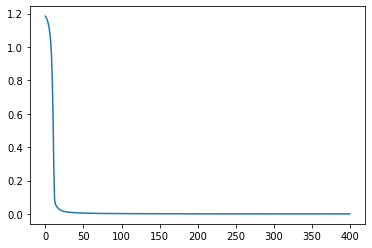

0.0005574182052387032

In [106]:
import matplotlib.pyplot as plt
plt.plot(performance)
plt.show()
np.min(performance)

In [43]:
import tkinter as tk

class GUI:
    
    class MainWindowC:
        def __init__(self):
            self.main = tk.Tk()
            
            self.main.geometry("1000x800")
            self.create_widgets()
            
            self.main.mainloop()
        def create_widgets(self):
            
            self.labelTitle = tk.Label(self.main,text="NNFS")
            self.labelTitle.config(font=("FreeSans",30))
            self.labelTitle.grid(row=0,column=0)
            
            
            self.buttonQuit = tk.Button(self.main, text="213")
            self.buttonQuit.grid(row=0,column=1,padx=20)
    
    def __init__(self):
        self.mainWindowO = self.MainWindowC()
    

GUI()

In [5]:
import tkinter as tk

class Application( tk.Frame ):
    
    def __init__( self , master=None ):
        super().__init__( master )
        self.master = master
        self.pack()
        self.create_widgets()
        
    def create_widgets(self):
        self.hi_there = tk.Button(self)
        self.hi_there["text"] = "Hello World\n(click me)"
        self.hi_there["command"] = self.say_hi
        self.hi_there.pack(side="top")

        self.quit = tk.Button(self, text="QUIT", fg="red",
                              command=self.master.destroy)
        self.quit.pack(side="bottom")
        
    def say_hi(self):
        print("hi there, everyone!")
    
root = tk.Tk()
app = Application(master=root)
app.mainloop()

a


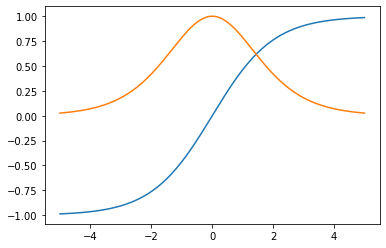

In [78]:
import matplotlib.pyplot as plt
x=np.linspace(-5,5,201)
y=ActivationFunctions.bipolar(x)
der = 1.0-(y*y)
plt.plot(x,y)
plt.plot(x,der)
plt.show()

In [469]:
(np.linalg.norm(one[1]-two[1])/np.linalg.norm(one[1]+two[1]),np.linalg.norm(one[1]+two[1])/np.linalg.norm(one[1]-two[1]))

TypeError: 'NoneType' object is not subscriptable

In [438]:
inpu=np.array([0,0,1,0])
model.compileModel()
# print(np.dot(np.array([[0.,0.,1.,0.]]),model.structure[0].matrix))

for i in model.structure:
    print(inpu)
    inpu=i.forward(inpu)
print(inpu)

[0 0 1 0]
[0.92207355 0.55702447 0.72153182 0.35094724]
[0.08588492]


In [439]:
(np.array([[1,1],[1,1],[1,1]]).T*np.array([2,2,2])).T

array([[2, 2],
       [2, 2],
       [2, 2]])

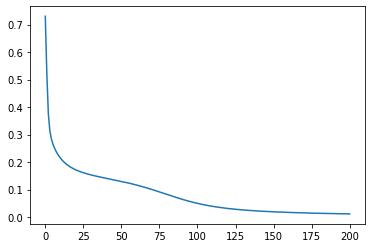

In [158]:
plt.plot(performance)
plt.show()

In [41]:
model.evaluate()

array([0.99995269])

In [43]:
for y,x in zip(train_dataset['endo'],train_dataset['egzo']):
    print(model.forward(x),y)
    
    

[0.49680155] [0.75]
[0.49587065] [0.25]
[0.497375] [0.25]
[0.49604188] [0.75]
[0.4972204] [0.25]
[0.49721244] [0.75]
[0.49778453] [0.75]
[0.49774981] [0.25]
[0.49921718] [0.25]
[0.49727964] [0.75]
[0.49913612] [0.75]
[0.49650289] [0.25]
[0.49947496] [0.75]
[0.4993943] [0.25]
[0.49948657] [0.25]
[0.49937549] [0.75]



Taka jest docelowa funckja LOSS czyli taka którą minimalizujemy.

```1```- indidator function https://www.wikiwand.com/en/Indicator_function

```i``` iteruje sie po obserwacjach

```c``` iteruje sie po klasach

$p_{model} [y_i \in C_c ]$ prawdopodobieństwo, że obserwacja i należy do klasy c

$-1/N*\Sigma_{i=1} ^N \Sigma_{c=1} ^C 1_{y_{i} \in C_{c}} log(p_{model}[y_i \in C_{c}]) $

In [54]:
"""
network.py
~~~~~~~~~~
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print(f"Epoch {j}: {self.evaluate(test_data)} / { n_test}")
            else:
                print(f"Epoch {j} complete")

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)########
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass

        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) #!!!
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))
nn=Network([4,3,2])
x=[[1,1,0,0],[1,0,0,0],[0,1,0,0],[0,0,0,0],[1,1,1,0],[1,0,1,0],[0,1,1,0],[0,0,1,0],[1,1,0,1],[1,0,0,1],[0,1,0,1],[0,0,0,1],[1,1,1,1],[1,0,1,1],[0,1,1,1],[0,0,1,1]]
y=[[1,0],      [0,1],      [0,1],      [1,0],      [0,1],      [1,0],      [1,0],      [0,1],      [0,1],      [1,0],      [1,0],      [0,0],      [1,0],      [0,1],      [0,1],      [1,0]]
nn.SGD(list(zip(x,y)),1,2,0.1)


ValueError: operands could not be broadcast together with shapes (2,3) (2,) 